In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from power_plant_dataset import PowerPlantDataset
import os

dataset_fd = PowerPlantDataset(csv_file='fdcl/split/df_fd.csv')# 风电
dataset_gf = PowerPlantDataset(csv_file='fdcl/split/df_gf.csv')# 光伏
dataset_hdrm = PowerPlantDataset(csv_file='fdcl/split/df_hdrm.csv')# 火电燃煤
dataset_sdyg = PowerPlantDataset(csv_file='fdcl/split/df_sdyg.csv')# 水电有功

# 定义模型
class PolynomialRegressor(nn.Module):
    def __init__(self, degree):
        super(PolynomialRegressor, self).__init__()
        self.degree = degree
        self.coefficients_mean = nn.Parameter(torch.randn(degree + 1))  # 预测均值的系数
        self.coefficients_std = nn.Parameter(torch.randn(degree + 1))  # 预测标准差的系数

    def forward(self, x):
        mean = sum(self.coefficients_mean[i] * x.pow(i) for i in range(self.degree + 1))
        std = torch.exp(sum(self.coefficients_std[i] * x.pow(i) for i in range(self.degree + 1)))  # 确保标准差为正
        return mean, std


model_fd = PolynomialRegressor(degree=3)
model_gf = PolynomialRegressor(degree=3)
model_hdrm = PolynomialRegressor(degree=3)
model_sdyg = PolynomialRegressor(degree=3)

# 模型文件列表
model_files = ['fdcl/fd.pth', 'fdcl/gf.pth', 'fdcl/hdrm.pth', 'fdcl/sdyg.pth']

# 模型列表
models = [model_fd, model_gf, model_hdrm, model_sdyg]

# 遍历每个模型文件
for model_file, model in zip(model_files, models):
    # 检查模型文件是否存在
    if os.path.exists(model_file):
        # 如果模型文件存在，加载模型参数
        model.load_state_dict(torch.load(model_file))
    else:
        print(f"模型参数文件 '{model_file}' 不存在.")


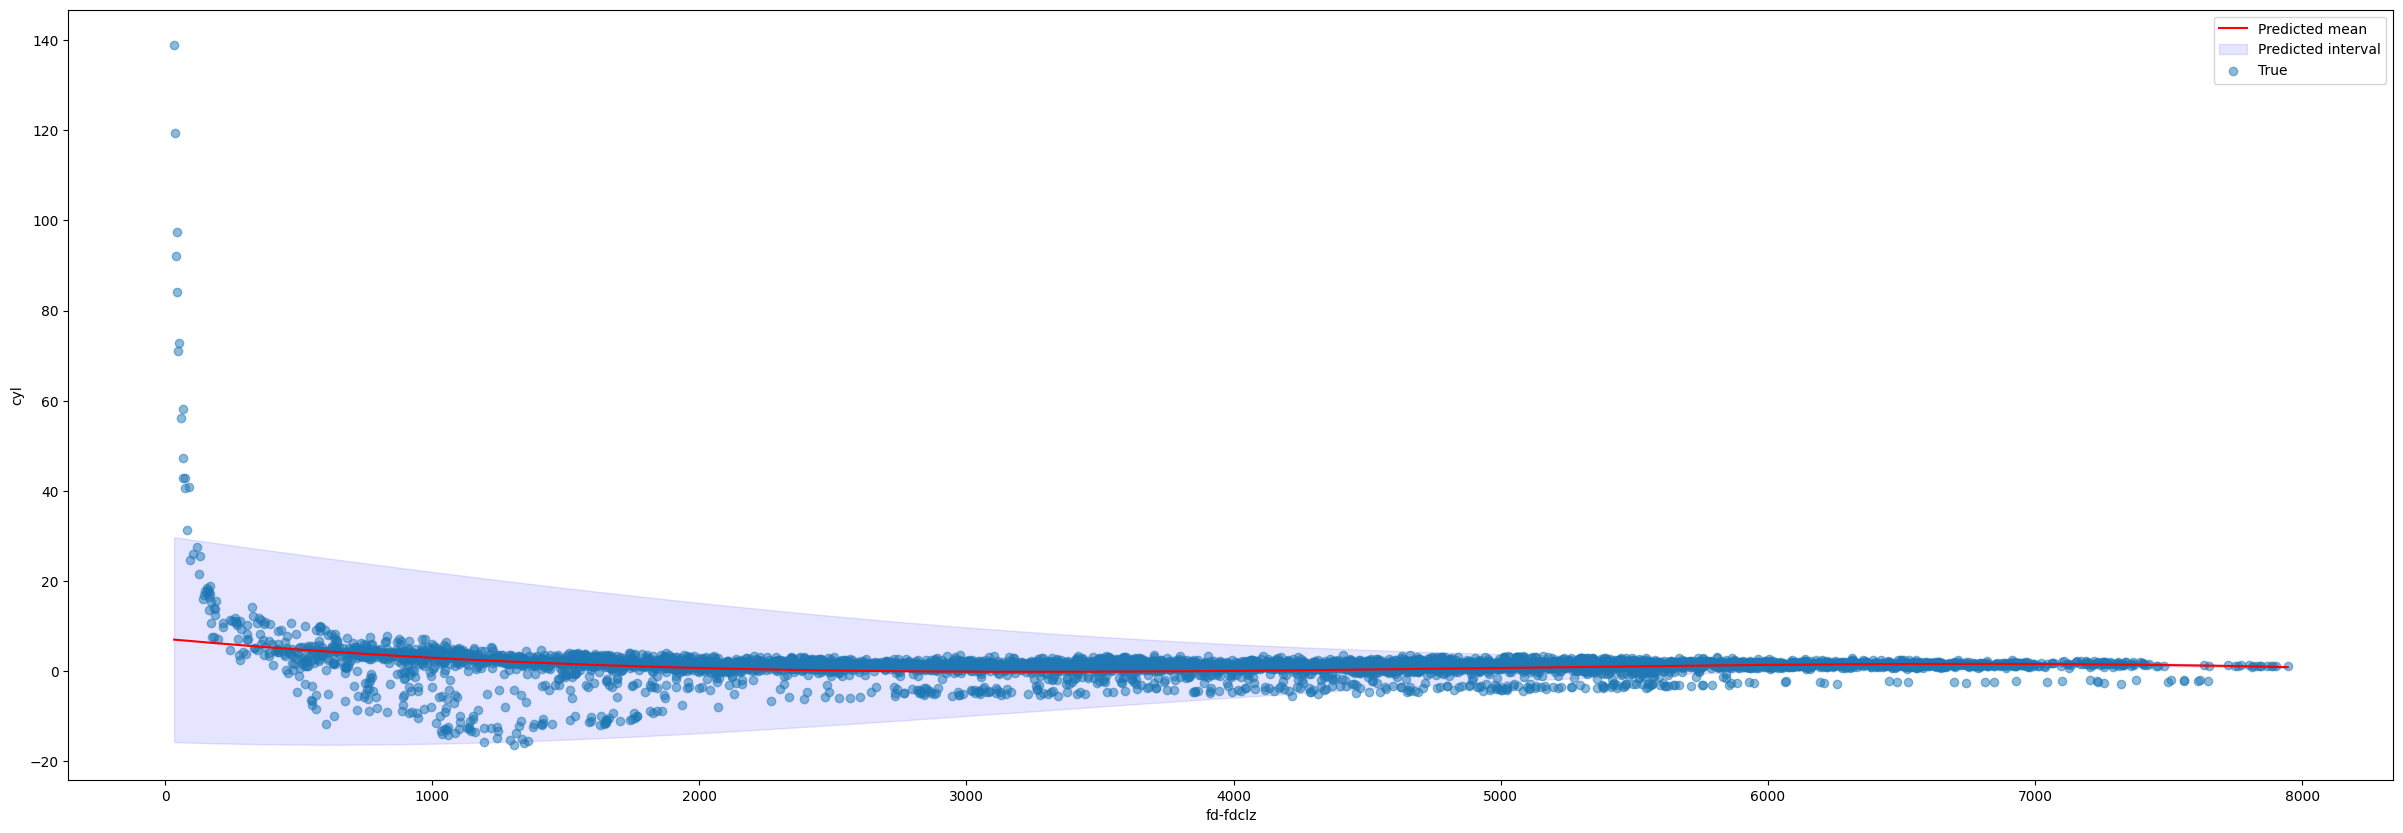

厂用率预测覆盖 fd: 96.72%

输入x= [[6090.554]]
预测均值mean= [[1.4648167]]
预测方差std: [[-15.616782]]

预测区间: [[0.17158192]] ～ [[2.7580516]]

预测均值的多项式： 0.1500510275363922 * x^0 + -0.2683112919330597 * x^1 + 0.48644891381263733 * x^2 + -0.25747960805892944 * x^3
预测方差的多项式： exp(-2.614785671234131 * x^0 + -1.1063677072525024 * x^1 + -2.5934770107269287 * x^2 + -1.1127482652664185 * x^3)


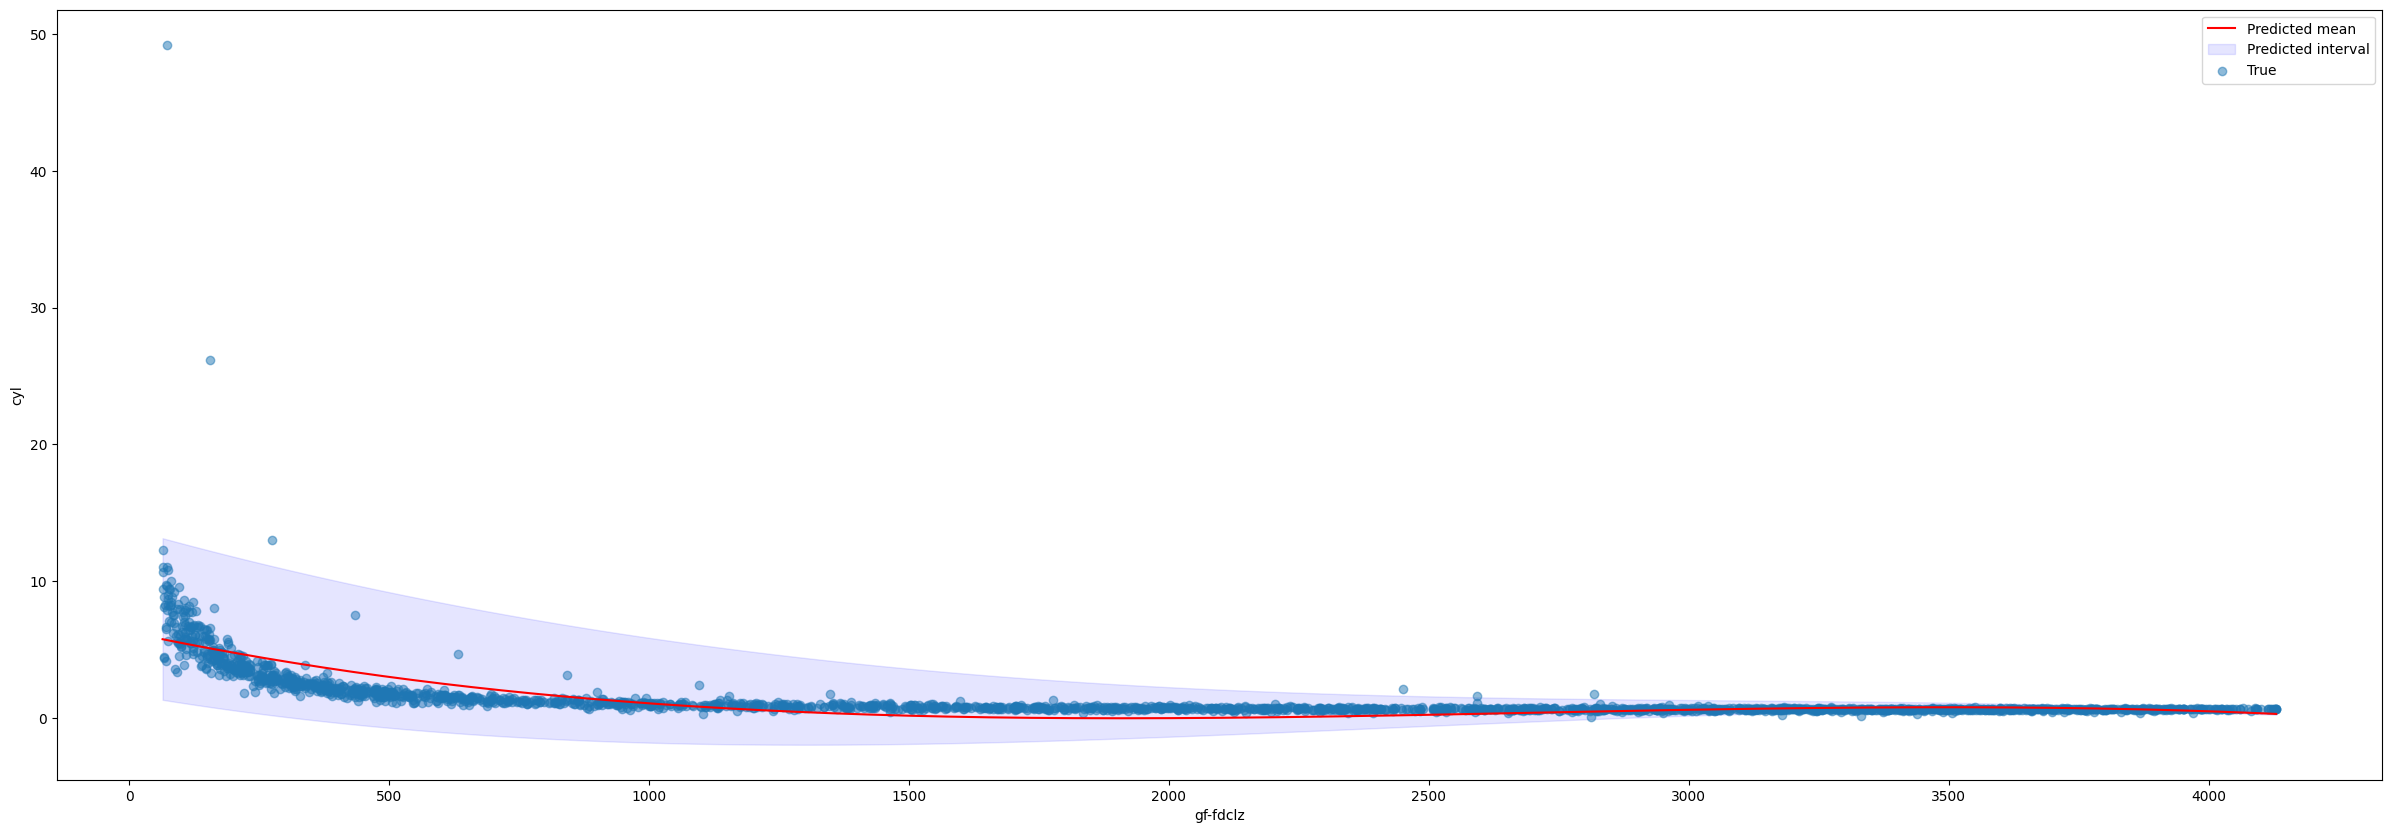

厂用率预测覆盖 gf: 95.69%

输入x= [[3225.4314]]
预测均值mean= [[0.7057644]]
预测方差std: [[0.23613276]]

预测区间: [[0.3964153]] ～ [[1.2213464]]

预测均值的多项式： 0.11611491441726685 * x^0 + -0.6314900517463684 * x^1 + 1.070668339729309 * x^2 + -0.5502572059631348 * x^3
预测方差的多项式： exp(-2.8123841285705566 * x^0 + -1.4534473419189453 * x^1 + -1.5708119869232178 * x^2 + -1.2390637397766113 * x^3)


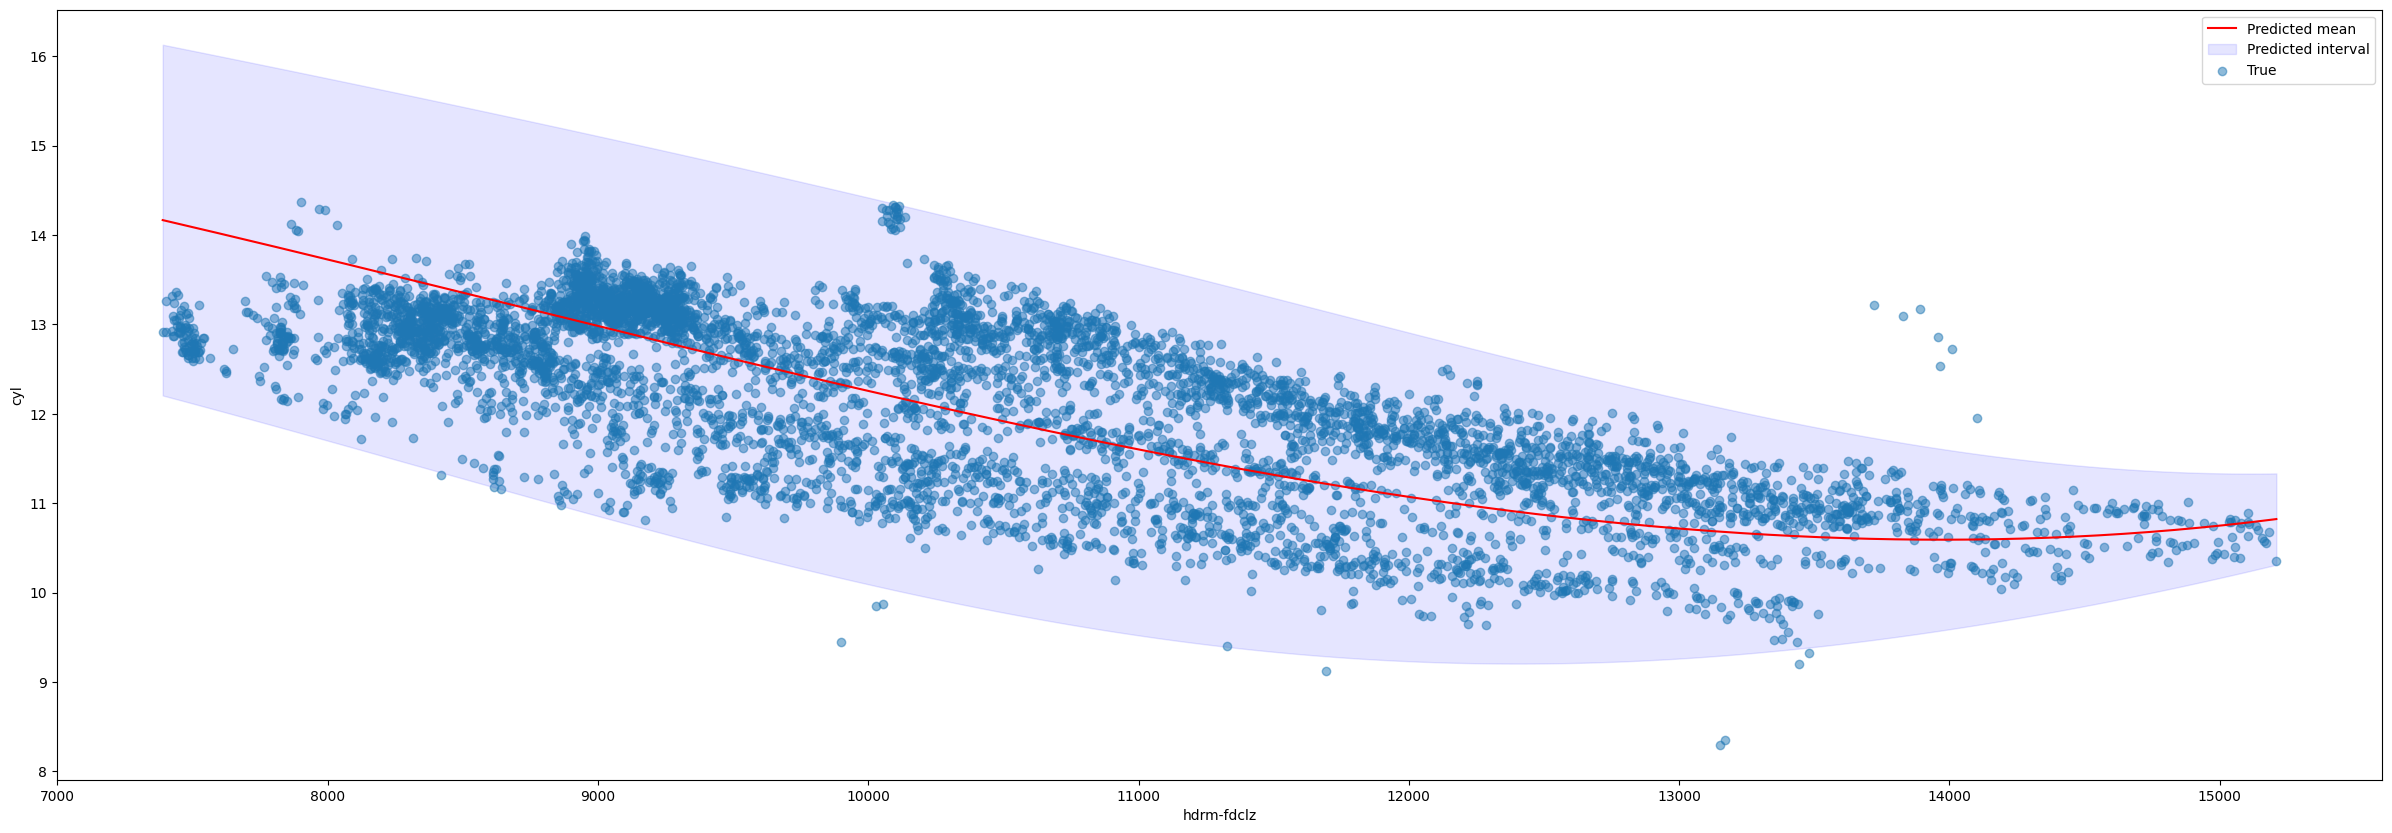

厂用率预测覆盖 hdrm: 99.75%

输入x= [[9442.573]]
预测均值mean= [[12.65534]]
预测方差std: [[10.0915575]]

预测区间: [[10.501392]] ～ [[14.809288]]

预测均值的多项式： 0.9674301147460938 * x^0 + -0.9090405702590942 * x^1 + -0.33470386266708374 * x^2 + 0.6924334764480591 * x^3
预测方差的多项式： exp(-1.3111510276794434 * x^0 + 0.3933233618736267 * x^1 + 0.4173588752746582 * x^2 + -2.156473159790039 * x^3)


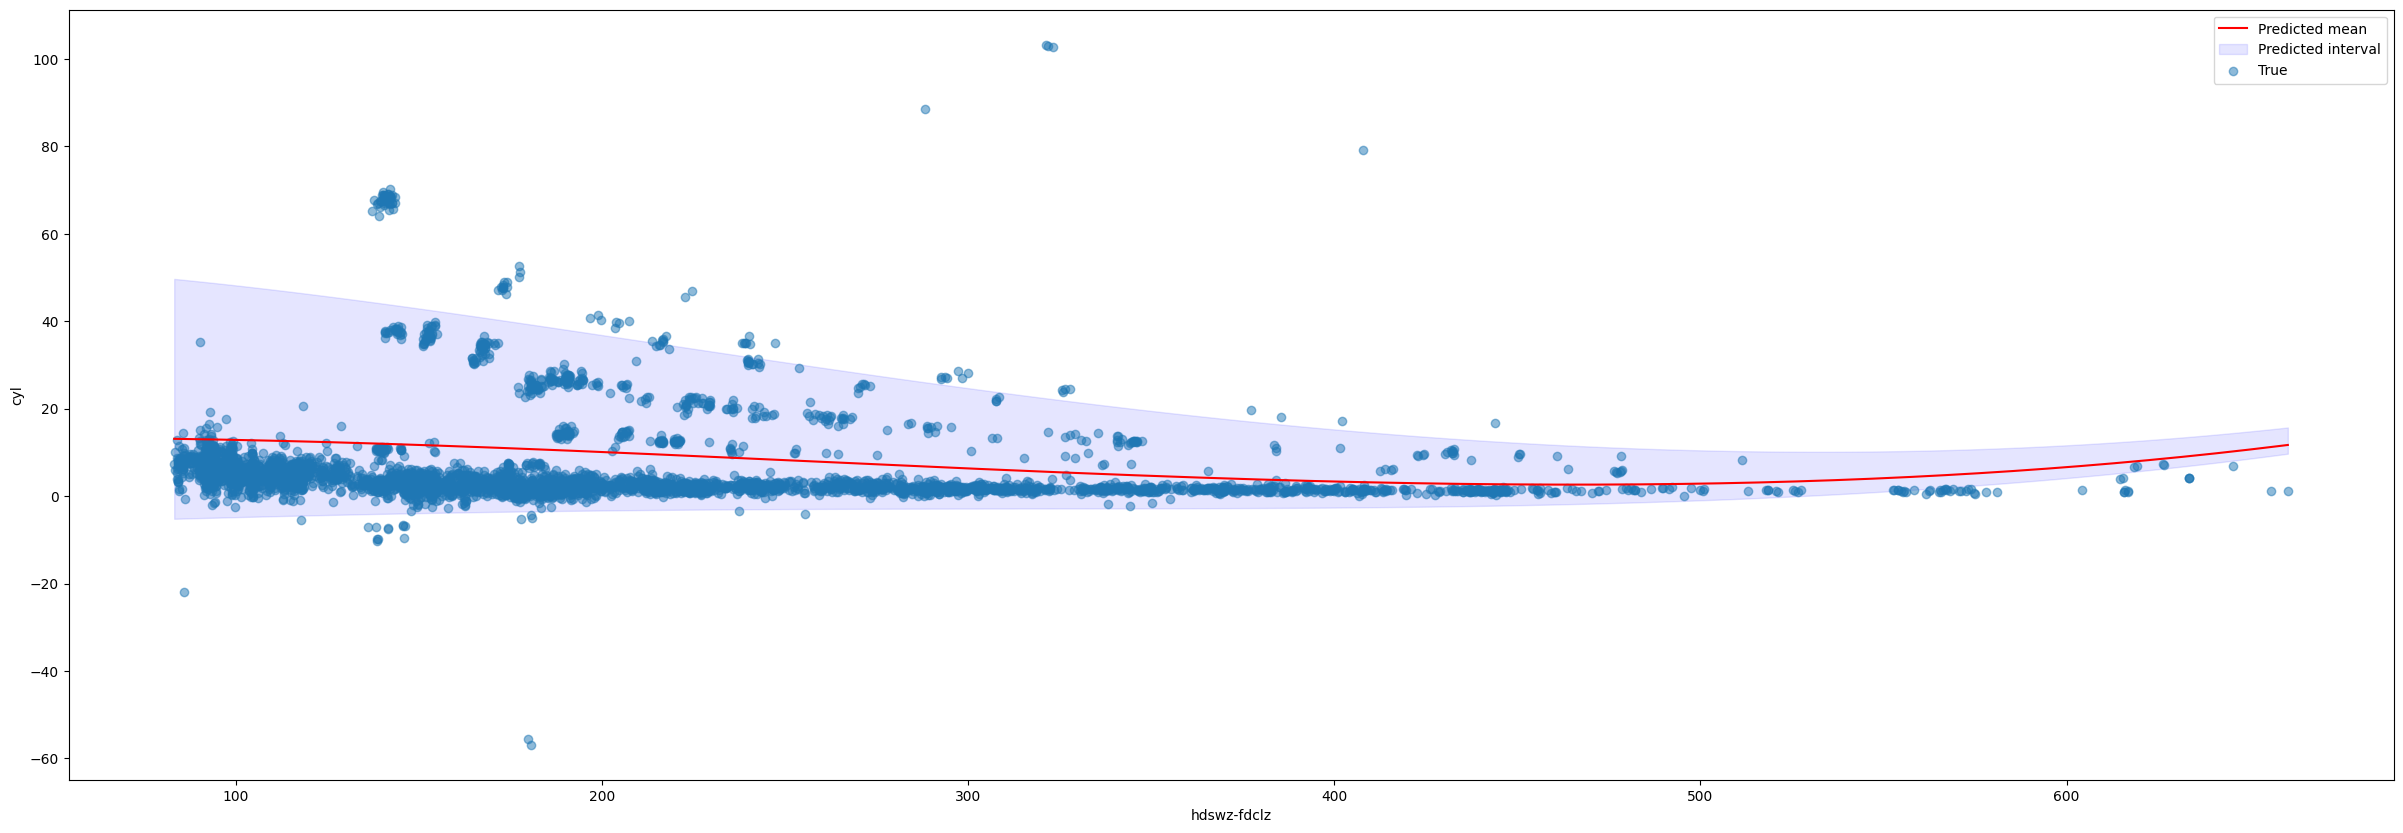

厂用率预测覆盖 hdswz: 97.51%

输入x= [[518.1373]]
预测均值mean= [[3.16714]]
预测方差std: [[-49.84815]]

预测区间: [[-0.3533381]] ～ [[10.208092]]

预测均值的多项式： 0.43699774146080017 * x^0 + -0.04366454854607582 * x^1 + -0.3149361312389374 * x^2 + 0.34983569383621216 * x^3
预测方差的多项式： exp(-1.4763108491897583 * x^0 + -1.1087961196899414 * x^1 + -2.4314024448394775 * x^2 + 1.3271512985229492 * x^3)


In [2]:
from scipy.interpolate import interp1d

# 数据集列表
datasets = [dataset_fd, dataset_gf, dataset_hdrm, dataset_sdyg]

# x轴标签列表
x_labels = ['fd', 'gf', 'hdrm', 'hdswz', 'sdyg']

# 置信区间大小设置
std_coefficients_upper = [2,2.5,1.2,1]
std_coefficients_low = [2,1.5,1.2,0.5]

# 遍历每个模型和数据集
for model, dataset, x_label, std_coefficient_upper,std_coefficient_low in zip(models, datasets, x_labels,std_coefficients_upper,std_coefficients_low ):
    # 用于存储dataset值的列表
    features_list = []
    real_outputs = []

    # 遍历数据集
    for i in range(len(dataset)):
        # 获取特征和标签
        features, label = dataset[i]

        # 将特征和标签添加到dataset值列表
        features_list.append(features.item())
        real_outputs.append(label.item())

    # 将真实值逆向标准化
    real_features_list = dataset.inverse_transform_features(np.array(features_list).reshape(-1, 1))
    real_outputs = dataset.inverse_transform_labels(np.array(real_outputs).reshape(-1, 1))

    # 根据特征值对真实值进行排序
    sorted_indices = np.argsort(real_features_list, axis=0).flatten()
    real_features_list = real_features_list[sorted_indices]
    real_outputs = real_outputs[sorted_indices]

    # 创建一个新的特征数组，用于模型预测
    new_features = np.linspace(min(features_list), max(features_list), 500).reshape(-1, 1)

    # 将numpy数组转换为PyTorch张量
    new_features_torch = torch.from_numpy(new_features).float()

    # 使用模型进行预测
    mean, std = model(new_features_torch)

    # 将预测值逆向标准化
    low = dataset.inverse_transform_labels((mean-std_coefficient_low*std).detach().numpy())
    upper = dataset.inverse_transform_labels((mean+std_coefficient_upper*std).detach().numpy())
    mean = dataset.inverse_transform_labels((mean).detach().numpy())

    # 逆向标准化新的特征数组，用于绘图
    new_features_real = dataset.inverse_transform_features(new_features)

    plt.figure(figsize=(30, 10))
    # 绘制预测的均值和区间
    plt.plot(new_features_real, mean, 'r-', label='Predicted mean')
    plt.fill_between(new_features_real.flatten(), low.flatten(), upper.flatten(), color='b', alpha=0.1, label='Predicted interval')

    # 绘制真实值
    plt.scatter(real_features_list, real_outputs, label='True', alpha=0.5)

    plt.xlabel(x_label+'-fdclz')
    plt.ylabel('cyl')
    plt.legend()
    plt.show()
    
    interp_low = interp1d(new_features_real.flatten(), low.flatten(), bounds_error=False, fill_value="extrapolate")
    interp_upper = interp1d(new_features_real.flatten(), upper.flatten(), bounds_error=False, fill_value="extrapolate")

    # 在真实特征值上评估插值函数
    low_interp = interp_low(real_features_list.flatten())
    upper_interp = interp_upper(real_features_list.flatten())

    # 计算真实值是否在预测的置信区间内
    in_interval = np.logical_and(real_outputs.flatten() >= low_interp, real_outputs.flatten() <= upper_interp)

    # 计算覆盖率
    coverage_rate = np.mean(in_interval)
    
    print(f"厂用率预测覆盖 {x_label}: {coverage_rate:.2%}\n")
    
    # 从 new_features_real 中随机选择一个数
    random_feature = np.random.choice(new_features_torch.flatten())

    # 将其转换为 PyTorch 张量
    random_feature_torch = torch.tensor([[random_feature]]).float()

    # 使用模型进行预测
    mean, std = model(random_feature_torch)

    # 输出预测结果
    print(f"输入x= {dataset.inverse_transform_features(random_feature.reshape(-1, 1))}")
    print(f"预测均值mean= {dataset.inverse_transform_labels(mean.detach().numpy())}")
    print(f"预测方差std: {dataset.inverse_transform_labels(std.detach().numpy())}\n")
    print(f"预测区间: {dataset.inverse_transform_labels(mean.detach().numpy()-std_coefficient_low*std.detach().numpy())} ～ {dataset.inverse_transform_labels(mean.detach().numpy()+std_coefficient_upper*std.detach().numpy())}\n")
    
    # 获取模型的系数
    coefficients_mean = model.coefficients_mean.detach().numpy()
    coefficients_std = model.coefficients_std.detach().numpy()

    # 构建多项式
    polynomial_mean = " + ".join(f"{coefficients_mean[i]} * x^{i}" for i in range(model.degree + 1))
    polynomial_std = "exp(" + " + ".join(f"{coefficients_std[i]} * x^{i}" for i in range(model.degree + 1)) + ")"

    # 输出多项式
    print(f"预测均值的多项式： {polynomial_mean}")
    print(f"预测方差的多项式： {polynomial_std}")